# <center> <font color=#B40404>Computer Vision & CNN Project 2</center>
    
## <center> <font color=#B40404>Submitted by Utathya Ghosh</center>
    
### <center> <font color=#B40404>Batch - AIML Online Jan 21-A</center>

# <center>PART ONE</center>
# <center>PROJECT BASED</center>
# <center>TOTAL SCORE - 30</center>

DOMAIN: Entertainment

CONTEXT: Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company  wants  to  automate  the  process  of  cast  and  crew  information  in  each  scene  from  a  movie  such  that  when  a  user  pauses  on  the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.

DATA DESCRIPTION: The dataset comprises of images and its mask where there is a human face.

PROJECT OBJECTIVE: Face detection from training images.

In [1]:
import numpy as np
from google.colab import drive
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input
from matplotlib import pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
print(tf.__version__)
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16 as PTModel
from collections import defaultdict, OrderedDict
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, UpSampling2D, BatchNormalization, Activation
import matplotlib.pyplot as plt
import cv2

2.6.0


Steps and tasks: [ Total Score: 20 points]

#### 1.Import the dataset

In [2]:
# Load google drive for all data
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load filename of all images
file_name = "/content/drive/My Drive/Data/Part 1- Train data - images.npy"

# Load all data
data = np.load(file_name, allow_pickle=True)

#### 2.Create features (images) and labels (mask) using that data.

In [4]:
# Initialise storage for featues (images) and labels (mask)
X_train = []
y_train = []

# Initialise count and total for progress visualisation
cnt = 0
tot = len(data)

# Loop through the entire available data
for i in range(len(data)):
  # Read image
  img = Image.fromarray(data[i][0])
  # initialize mask to all zeroes (black pixels) based on size or original image
  mask = np.zeros((img.size[1],img.size[0]),dtype=np.uint8)

  # Extract bounding box information
  for n in range(len(data[i][1])):

    xmin = int(data[i][1][n]["points"][0]['x'] * data[i][1][n]['imageWidth'])
    ymin = int(data[i][1][n]["points"][0]['y'] * data[i][1][n]['imageHeight'])
    xmax = int(data[i][1][n]["points"][1]['x'] * data[i][1][n]['imageWidth'])
    ymax = int(data[i][1][n]["points"][1]['y'] * data[i][1][n]['imageHeight'])

    # fill with bounding box with white pixels
    mask[ymin:ymax,xmin:xmax] = 255

  # Resize features (images)
  img = img.resize((224, 224), Image.ANTIALIAS) # Resize image
  img = img.convert('RGB')

  # Resize Labels (mask)
  mask = Image.fromarray(mask)
  mask = mask.resize((224, 224), Image.ANTIALIAS) # Resize image
  mask = mask.convert('RGB')

  # Preprocess and load features (images) into designated variable
  X_train.append(preprocess_input(np.array(img, dtype=np.float32))) # Convert to float32 array

  # Load Labels (mask) into designated variable
  y_train.append(np.array(mask, dtype=np.float32))

  # Progress report visualisation
  cnt+=1
  clear_output(wait=True)
  print("Completed : %.2f%%" %((cnt/tot)*100))

Completed : 100.00%


###### <font color=#B40404>We are going to split the feature and labels into 2 sets (train and validation) only. Originally we would also create a test set but we do not want training to happen on a lower number of records. Hence the decision to forego creating the test set from the data provided.

In [5]:
# Split data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 3.Mask detection model:
###### Design a face mask detection model. Hint: Use U-net along with pre-trained transfer learning models

In [10]:
# Preprocess data for the final fit into the U-Net model
tf_X_train = tf.convert_to_tensor(X_train)
tf_y_train = tf.convert_to_tensor(norm(y_train))
tf_X_val = tf.convert_to_tensor(X_val)
tf_y_val = tf.convert_to_tensor(norm(y_val))

In [11]:
# Load VGG Pre-trained model using imagenet weights
base_pretrained_model = PTModel(input_shape =  tf_X_train.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

# Visualise the model
base_pretrained_model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [12]:
# Initialisation
layer_size_dict = defaultdict(list)
inputs = []

# Loop through layers of Pre-trained model
for lay_idx, c_layer in enumerate(base_pretrained_model.layers):
    # Organise layers into input layers
    if not c_layer.__class__.__name__ == 'InputLayer':
        layer_size_dict[c_layer.get_output_shape_at(0)[1:3]] += [c_layer]
    else:
        inputs += [c_layer]

# Freeze dict
layer_size_dict = OrderedDict(layer_size_dict.items())

# Display Layer size and layer task
for k,v in layer_size_dict.items():
    print(k, [w.__class__.__name__ for w in v])

(224, 224) ['Conv2D', 'Conv2D']
(112, 112) ['MaxPooling2D', 'Conv2D', 'Conv2D']
(56, 56) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(28, 28) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(14, 14) ['MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D']
(7, 7) ['MaxPooling2D']


In [13]:
# Take the last layer of each shape and make it into an output
pretrained_encoder = Model(inputs = [v[0].get_input_at(0) for k, v in layer_size_dict.items()][0], 
                           outputs = [v[-1].get_output_at(0) for k, v in layer_size_dict.items()])
pretrained_encoder.trainable = False

CPU times: user 7.21 ms, sys: 10 µs, total: 7.22 ms
Wall time: 8.85 ms


In [14]:
# Initialise size of image, Input Layer and Output Layer
x_wid, y_wid = tf_X_train.shape[1:3]
in_t0 = Input(tf_X_train.shape[1:], name = 'T0_Image')
wrap_encoder = lambda i_layer: {k: v for k, v in zip(layer_size_dict.keys(), pretrained_encoder(i_layer))}
t0_outputs = wrap_encoder(in_t0)
lay_dims = sorted(t0_outputs.keys(), key = lambda x: x[0])
skip_layers = 2
last_layer = None

# Loop through all layers jumping skipped layers
for k in lay_dims[skip_layers:]:
    cur_layer = t0_outputs[k]
    channel_count = cur_layer.shape[-1]
    cur_layer = Conv2D(channel_count//2, kernel_size=(3,3), padding = 'same', activation = 'linear')(cur_layer)
    # BatchNormalisation added for internal covariant shift
    cur_layer = BatchNormalization()(cur_layer) 
    cur_layer = Activation('relu')(cur_layer)
    
    # Connect previous feature maps for final spatial context
    if last_layer is None:
        x = cur_layer
    else:
        last_channel_count = last_layer.shape[-1]
        x = Conv2D(last_channel_count//2, kernel_size=(3,3), padding = 'same')(last_layer)
        x = UpSampling2D((2, 2))(x)
        x = concatenate([cur_layer, x])
    last_layer = x

# Creating the final output
final_output = Conv2D(tf_y_train.shape[-1], kernel_size=(1,1), padding = 'same', activation = 'sigmoid')(last_layer)

# Create the U-Net moel
unet_model = Model(inputs = [in_t0],
                  outputs = [final_output])

# Visualise the model
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 224, 224, 64 14714688    T0_Image[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 256)  1179904     model[0][3]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 256)  1024        conv2d[0][0]                     
____________________________________________________________________________________________

###### Design your own Dice Coefficient and Loss function.

In [16]:
def dice_coefficient(y_true, y_pred):
    # Calculate Numerator (2* Union of y_true and y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    # Calculate Denominator (number of y_true + number of y_pred)
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    # Return dice coefficient, epsilon at the end is to avoid dividing by zero
    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    # Return loss calculation
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

def norm(data):
  # Initialise new input variable
  input = []
  # Loop through data
  for i in range(len(data)):
    # Normalise data between 0 and 1 range from 0 - 255 range
    input.append((data[i] / 255.).astype(np.float32))
  return input

###### Train, tune and test the model.

In [ ]:
# Create Early stop hyperparameters
stop = EarlyStopping(monitor="val_loss", patience=6)

# Reduce learning rate based on val_loss parameters
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Create callback list
callbacks_list = [stop, reduce_lr]

# Design the optimiser
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the unet model
unet_model.compile(optimizer=optimizer, 
                   loss=binary_crossentropy, 
                   metrics=[dice_coefficient])

In [17]:
# Train and Tune the U-Net model
history = unet_model.fit(tf_X_train, tf_y_train, 
                         validation_data = (tf_X_val, tf_y_val), 
                         epochs=25, batch_size=32, verbose=1,
                         callbacks=callbacks_list)

Epoch 1/25
11/11 [==============================] - 494s 45s/step - loss: 0.7426 - dice_coefficient: 0.3781 - val_loss: 1.4663 - val_dice_coefficient: 0.3484
Epoch 2/25
11/11 [==============================] - 492s 45s/step - loss: 0.3640 - dice_coefficient: 0.5105 - val_loss: 0.4546 - val_dice_coefficient: 0.5524
Epoch 3/25
11/11 [==============================] - 493s 45s/step - loss: 0.2546 - dice_coefficient: 0.5331 - val_loss: 0.3675 - val_dice_coefficient: 0.4514
Epoch 4/25
11/11 [==============================] - 496s 45s/step - loss: 0.2027 - dice_coefficient: 0.5605 - val_loss: 0.3423 - val_dice_coefficient: 0.4901
Epoch 5/25
11/11 [==============================] - 495s 45s/step - loss: 0.1856 - dice_coefficient: 0.5859 - val_loss: 0.2450 - val_dice_coefficient: 0.5325
Epoch 6/25
11/11 [==============================] - 492s 45s/step - loss: 0.1718 - dice_coefficient: 0.5988 - val_loss: 0.2601 - val_dice_coefficient: 0.5051
Epoch 7/25
11/11 [==============================] - 

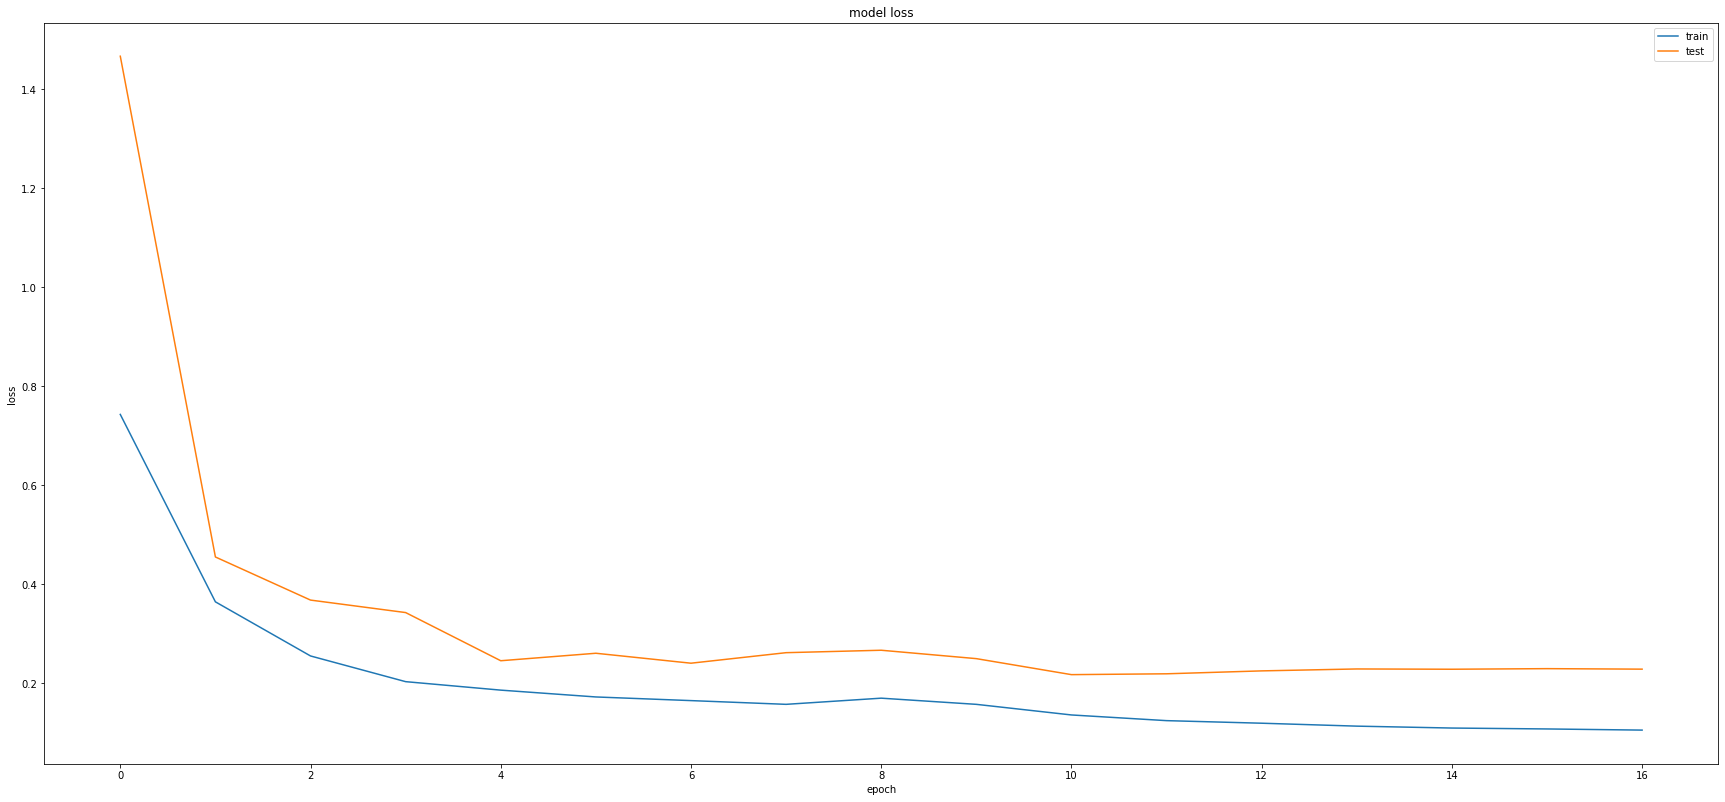

In [18]:
# Displaying the learning graph
plt.figure(figsize = (30, 30))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

###### <font color=#B40404>Training stopped early since the validation loss curve was slowly diverging from Training loss. Further training would increase overfitting.

#### 4.Use the “Prediction image” as an input to your designed model and display the output of the image

###### <font color=#B40404>Prediction image was not found/available and hence we pre-selected this (13) particular indexed record from the validation set for this question.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


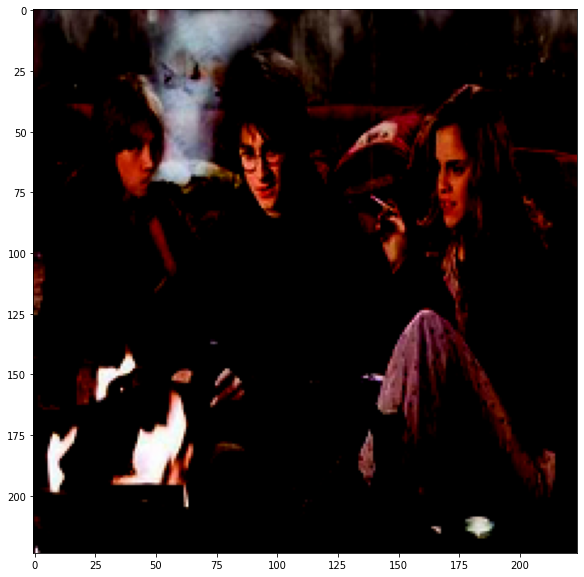

In [26]:
# Displaying the original image
idx = 13
plt.figure(figsize=(20,10))
plt.imshow(X_val[idx])

###### <font color=#B40404>Displaying results with decision boundary at 0.5 for the mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


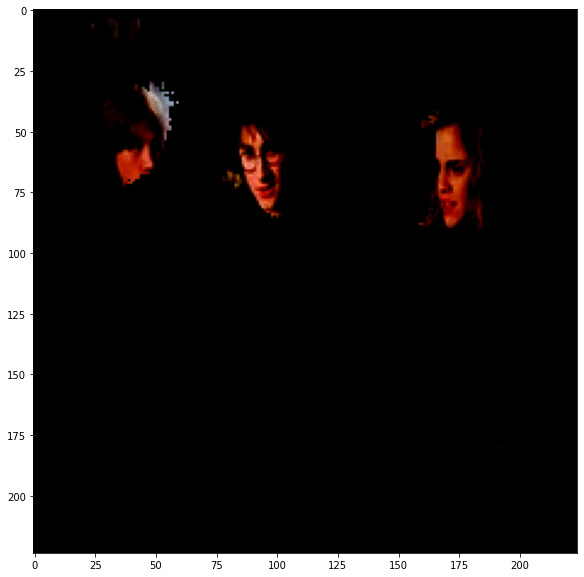

In [43]:
# Using our UNet model to mask the faces
# Take the original image
image = X_val[idx].copy()

# Predict the mask Using a decision boundary at 0.5
pred_mask = np.array(1.0*(unet_model.predict(x=np.array([tf.convert_to_tensor(X_val[idx])]))[0] > 0.5))[:, :, 0]

# Set the size of the image
plt.figure(figsize=(20,10))

# Create an image with the original picture as base and then on the next layer use the mask
out_image = image
out_image[:,:,0] = pred_mask*image[:,:,0]
out_image[:,:,1] = pred_mask*image[:,:,1]
out_image[:,:,2] = pred_mask*image[:,:,2]

# Plot final image
plt.imshow(out_image)

###### <font color=#B40404>Displaying results without decision boundary for the mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


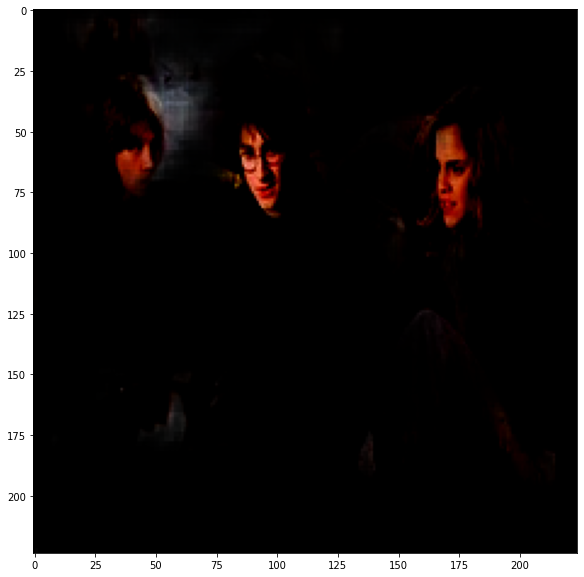

In [44]:
# Using our UNet model to mask the faces
# Take the original image
image = X_val[idx].copy()

# Predict the mask Using a decision boundary at 0.5
pred_mask = np.array(unet_model.predict(x=np.array([tf.convert_to_tensor(X_val[idx])]))[0])[:, :, 0]

# Set the size of the image
plt.figure(figsize=(20,10))

# Create an image with the original picture as base and then on the next layer use the mask
out_image = image
out_image[:,:,0] = pred_mask*image[:,:,0]
out_image[:,:,1] = pred_mask*image[:,:,1]
out_image[:,:,2] = pred_mask*image[:,:,2]

# Plot final image
plt.imshow(out_image)

In [46]:
!pip install keras_pickle_wrapper
# Pickling our model for later use

import pickle
from keras_pickle_wrapper import KerasPickleWrapper

# Wrap a compiled model
mw = KerasPickleWrapper(unet_model)

# Create Pickle file from the pipeline created around the final model
with open('final_model.pickle', 'wb') as dump_var:
    pickle.dump(mw, dump_var)

  Created wheel for keras-pickle-wrapper: filename=keras_pickle_wrapper-1.0.5-py3-none-any.whl size=3159 sha256=8b33a0be25e6c9fed1576c3062b25a46394e31cc913633e26faf9faf79d03304
  Stored in directory: /root/.cache/pip/wheels/e5/4e/4c/85c25b4196ee8d42bde8840af49b5629c2122a00902146867f
Successfully built keras-pickle-wrapper


In [ ]:
# Loading our final model
with open('final_model.pickle', 'rb') as pkl:
  final_model = pickle.load(pkl)

final_model().evaluate(X_train[test_mask], y_train[test_mask])

In [47]:
# Saving our pickle to the Drive
# !cp final_model.pickle "drive/My Drive/Data"